This notebook investiates the feature importance of the final model.

# Setup

## Basic Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from tensorflow.keras.saving import register_keras_serializable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import datetime
import random
import properscoring as ps

from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

import xgboost
import pydot
import graphviz

from keras.models import load_model
from sklearn.multioutput import MultiOutputRegressor
import pickle

from sklearn.model_selection import ParameterGrid
from pathlib import Path
import joblib
import shap
import os

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [3]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

c:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Probabilistic-Forecasting-of-Bicycle-Counts-in-Karlsruhe-with-Neural-Networks


In [4]:
plt.rcParams.update({'font.size': 14})

In [5]:
X_train = pd.read_pickle(r"data\X_train_final.pkl")
X_valid = pd.read_pickle(r"data\X_valid_final.pkl")
X_test = pd.read_pickle(r"data\X_test_final.pkl")

y_train = pd.read_pickle(r"data\y_train_final.pkl")
y_valid = pd.read_pickle(r"data\y_valid_final.pkl")
y_test = pd.read_pickle(r"data\y_test_final.pkl")


In [6]:
base_path_plots = Path(r"Figures\(16) Feature_Importance_Final_Model")

In [7]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [8]:
X_valid.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
359,-1.064496,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-0.258711,-0.353265,1
360,-0.478837,-0.397192,0,1,2,0.0,0.0,0.0,1.0,1.087091,-0.823509,1
361,-0.104279,0.143383,0,1,3,0.0,0.0,0.0,1.0,2.276769,-0.913940,1
362,-0.691404,0.169125,0,1,4,0.0,0.0,0.0,1.0,-0.674006,-0.508807,1
363,0.541485,-0.397192,0,0,5,0.0,0.0,0.0,1.0,1.564836,-0.201340,1


In [9]:
y_test.head()

0    1160.0
1    2996.0
2    3635.0
3    3265.0
4    3751.0
Name: bike_count, dtype: float64

In [10]:
X_train.shape, X_valid.shape, X_test.shape

((3161, 12), (364, 12), (390, 12))

In [11]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [12]:
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [13]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [14]:
X_train.isna().sum()

temperature                 0
precipitation               0
public_holiday_indicator    0
is_workday                  0
day_of_week                 0
spring                      0
summer                      0
autumn                      0
winter                      0
windspeed                   0
sun                         0
school_holiday_indicator    0
dtype: int64

In [15]:
X_train.dtypes

temperature                 float64
precipitation               float64
public_holiday_indicator      int64
is_workday                    int64
day_of_week                   int64
spring                      float64
summer                      float64
autumn                      float64
winter                      float64
windspeed                   float64
sun                         float64
school_holiday_indicator      int64
dtype: object

In [16]:
X_train.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,3.161000e+03,3.161000e+03,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3.161000e+03,3.161000e+03,3161.000000
mean,4.450726e-16,3.708939e-17,0.033534,0.684910,3.001898,0.243277,0.259412,0.259095,0.238216,4.832859e-17,4.720467e-17,0.232521
std,1.000158e+00,1.000158e+00,0.180054,0.464625,2.001106,0.429129,0.438381,0.438207,0.426059,1.000158e+00,1.000158e+00,0.422506
min,-2.660948e+00,-3.971923e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.513961e+00,-1.094803e+00,0.000000
25%,-7.932892e-01,-3.971923e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.364558e-01,-9.899026e-01,0.000000
50%,-9.270793e-04,-3.971923e-01,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-2.056287e-01,-2.085744e-01,0.000000
75%,7.907021e-01,-1.140338e-01,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,4.969366e-01,8.585175e-01,0.000000
max,2.566737e+00,1.461021e+01,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.952762e+00,2.193287e+00,1.000000


## Functions

In [17]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [18]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [19]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [20]:
def predict_and_calculate_mean_crps(model, X_test = X_test, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    crps_values = ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std)

    mean_crps = np.mean(crps_values)
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std, crps_values

In [21]:
def compile_and_fit_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [22]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [23]:
def process_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  X_test = X_test, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

# Feature Importances of final GridSearchCV model

## Loading the Grid Search CV model

In [24]:
@register_keras_serializable(package="Custom", name="crps_normal_cost_function")
def crps_normal_cost_function_v3(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    #print("y_true shape2: ", y_true.shape)
    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]
    
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    
     # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))   
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [25]:
@register_keras_serializable(package="Custom", name="crps_loss_function_wrapper")  
def crps_loss_function_wrapper(y_true, y_pred, tensor=True):
    """Wrapper for CRPS loss function.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """
    
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
       y_pred = tf.convert_to_tensor(y_pred.values)

    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = tf.convert_to_tensor(y_true.values, dtype=tf.float32)
        
    y_pred_reshaped = y_pred.reshape(-1, 2) #Keras Regressor flattens the values so they need to be reshaped

    crps = crps_normal_cost_function_v3(y_true, y_pred_reshaped, tensor)

    crps = crps.numpy()
    
    return crps

In [26]:
base_path = Path(r"hyperparameter_tuning_results\Final_GridSearch")

In [27]:
file_name_grid_search = "grid_search_tuned_v3.pkl"
file_path_grid_search = base_path / file_name_grid_search

In [28]:
loaded_grid_search_tuned = joblib.load(str(file_path_grid_search))

In [29]:
model = loaded_grid_search_tuned.best_estimator_.model_

In [30]:
mean_crps, predicted_mean_std, crps_values = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Mean CRPS: 302.85038590421107


In [31]:
cv_results = pd.DataFrame(loaded_grid_search_tuned.cv_results_)

In [32]:
cv_results['mean_test_score'] = cv_results['mean_test_score'] *-1

In [33]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,78.204610,18.691333,0.313856,0.110598,32,0.25,2,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-433.170929,-379.605652,-467.654449,426.810343,36.226054,2
1,82.485094,0.595056,0.311036,0.040606,32,0.25,4,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-388.475555,-360.662506,-446.990967,398.709676,35.978732,1
2,92.725573,0.280839,0.355519,0.040057,32,0.25,5,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-430.640564,-370.926575,-497.857666,433.141602,51.849570,3
3,102.334637,0.126687,0.345651,0.015663,32,0.25,6,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-416.934509,-375.472809,-527.739502,440.048940,64.275419,4


## Permutation Importance

In [34]:
def crps_scorer(estimator, X, y):
    """
    A wrapper for crps_normal_cost_function to work with Scikit-learn's scoring API.
    
    Args:
        estimator: Trained model with a `predict` method.
        X: Features (numpy array or pandas DataFrame).
        y: True target values (numpy array or pandas Series).

    Returns:
        Scalar score (negative CRPS for minimization).
    """
    # Generate predictions using the model
    y_pred = estimator.predict(X)  # Assuming [mean, std] output
    # Ensure y is a NumPy array
    y_true = y.to_numpy() if hasattr(y, "to_numpy") else y
    # Call the CRPS function (use tensor=False to avoid TensorFlow tensors)
    crps_values = crps_normal_cost_function(y_true, y_pred, tensor=False)
    # Return the mean CRPS as a negative value for minimization
    return -np.mean(crps_values)  # Negating for Scikit-learn's convention

In [35]:
result_baseline_model = permutation_importance(model, X_test, y_test, scoring=crps_scorer)
importances_baseline_model = result_baseline_model.importances_mean
importance_stds_baseline_model = result_baseline_model.importances_std

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

In [36]:
feature_names = X_test.columns

importance_df_baseline_model = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_baseline_model,
    'Std': importance_stds_baseline_model
}).sort_values(by='Importance', ascending=False)

print(importance_df_baseline_model)

                     Feature  Importance        Std
4                day_of_week  510.868164  23.811298
0                temperature  268.905151  10.808229
7                     autumn  261.189270  18.992676
5                     spring  212.201019  18.319120
6                     summer  208.225830   9.262218
8                     winter  190.648468  12.681725
3                 is_workday  168.218185  14.623944
11  school_holiday_indicator  130.208939   9.677645
2   public_holiday_indicator  109.188744   5.438396
1              precipitation   79.171104   9.093679
9                  windspeed   19.088861   2.999475
10                       sun   10.173114   1.660040


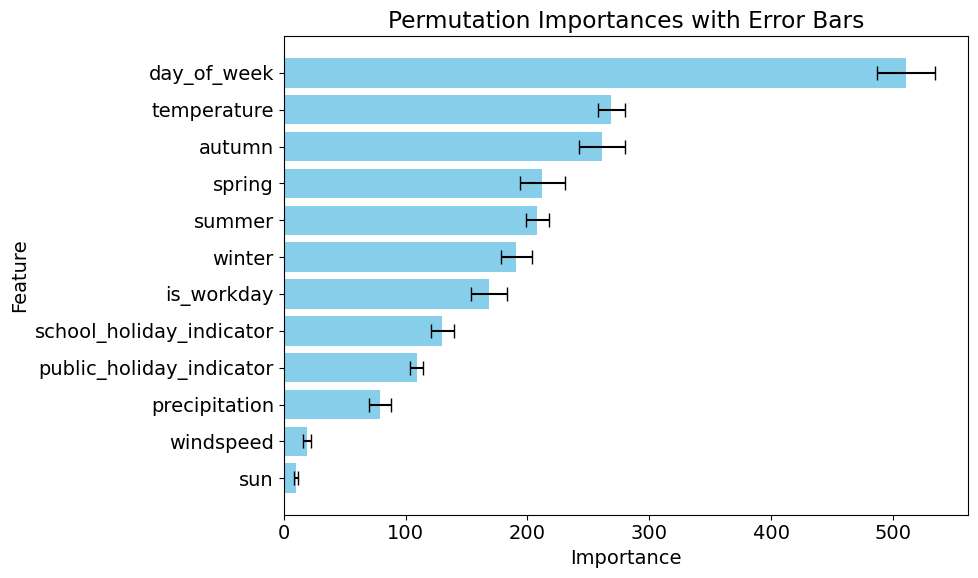

In [37]:
# Plot with error bars
feature_importance = plt.figure(figsize=(10, 6))
plt.barh( importance_df_baseline_model['Feature'], importance_df_baseline_model['Importance'], xerr=importance_df_baseline_model['Std'], color='skyblue', capsize=5 )
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances with Error Bars')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
feature_importance.figure.savefig(base_path_plots / "permutation_importance.png")

## SHAP

In [38]:
shap.initjs()

In [39]:
background_data = shap.sample(X_train, 100)

In [40]:
explainer_sample = shap.KernelExplainer(model.predict, background_data)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 


In [41]:
shap_values = explainer_sample.shap_values(X_test, nsamples=100)

  0%|          | 0/390 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
313/313 ━━━━━

### Mu

In [42]:
shap_values_mu = shap_values[:, :, 0]

In [43]:
shap_values_mu_df = pd.DataFrame(shap_values_mu, columns=X_test.columns)

In [44]:
shap_values_mu_df.to_csv(r"data\shap_values_df.csv", index=False)

In [45]:
shap_values_loaded_df = pd.read_csv(r"data\shap_values_df.csv")

In [46]:
shap_values_loaded_df.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,155.294263,0.000000,-1361.898995,-370.181963,-852.701864,-133.424365,-218.330714,-334.067395,0.000000,0.000000,0.000000,-524.629195
1,0.000000,-91.322626,132.492282,182.934021,294.489366,-200.578091,-247.379451,-358.102130,-303.018670,0.000000,-162.308535,-1040.208527
2,-402.900003,174.895330,108.860314,252.652906,449.784328,-144.898696,-213.429789,-330.001870,-357.592292,71.231026,6.859461,-980.565615
3,-153.397391,129.818614,149.105683,263.945016,478.005422,-218.213190,-209.696656,-347.794238,-218.543259,-340.256477,-278.763327,-1009.183018
4,25.521166,129.167674,111.397419,201.998344,486.126922,-199.141460,-268.789284,-355.487078,-150.431300,-120.075491,-240.679276,-1030.376355


In [47]:
shap_values_mu_loaded = shap_values_loaded_df.to_numpy()

In [48]:
shap_values_mu_loaded.shape

(390, 12)

In [49]:
shap_values_mu_explanation = shap.Explanation(values=shap_values_mu_loaded, data=X_test)
shap_values_mu_explanation

.values =
array([[  155.29426292,     0.        , -1361.8989947 , ...,
            0.        ,     0.        ,  -524.62919543],
       [    0.        ,   -91.32262583,   132.49228202, ...,
            0.        ,  -162.30853483, -1040.20852744],
       [ -402.90000301,   174.89532971,   108.86031396, ...,
           71.23102564,     6.8594607 ,  -980.56561505],
       ...,
       [ -152.45427475,   107.61558828,   162.88755175, ...,
         -220.14983194,   -66.65855195,   212.45887716],
       [  156.93252921,  -137.31180467,   138.29182019, ...,
         -241.08191703,  -256.06145744,   148.63060762],
       [  -95.99578842,    17.34581148,   122.7245691 , ...,
           33.40103038,   -78.68875351,   197.54488687]])

.data =
     temperature  precipitation  public_holiday_indicator  is_workday  \
0       0.156666      -0.397192                         1           0   
1      -0.267002       0.014675                         0           1   
2      -0.832871      -0.397192          

In [50]:
shap_values_loaded_df

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,155.294263,0.000000,-1361.898995,-370.181963,-852.701864,-133.424365,-218.330714,-334.067395,0.000000,0.000000,0.000000,-524.629195
1,0.000000,-91.322626,132.492282,182.934021,294.489366,-200.578091,-247.379451,-358.102130,-303.018670,0.000000,-162.308535,-1040.208527
2,-402.900003,174.895330,108.860314,252.652906,449.784328,-144.898696,-213.429789,-330.001870,-357.592292,71.231026,6.859461,-980.565615
3,-153.397391,129.818614,149.105683,263.945016,478.005422,-218.213190,-209.696656,-347.794238,-218.543259,-340.256477,-278.763327,-1009.183018
4,25.521166,129.167674,111.397419,201.998344,486.126922,-199.141460,-268.789284,-355.487078,-150.431300,-120.075491,-240.679276,-1030.376355
...,...,...,...,...,...,...,...,...,...,...,...,...
385,-815.289989,130.910842,0.000000,-514.494700,-1472.802703,-185.889138,-326.723244,-446.081509,397.487216,97.087572,0.000000,97.083818
386,-231.533980,-505.205279,102.379496,248.492647,400.579683,-224.068320,-212.941853,-305.601094,73.130471,-174.912275,-324.733701,212.816872
387,-152.454275,107.615588,162.887552,316.578663,548.001451,-151.005913,-221.773328,-215.415383,29.372996,-220.149832,-66.658552,212.458877
388,156.932529,-137.311805,138.291820,306.483721,632.672955,-165.657127,-199.261066,-249.559685,24.827510,-241.081917,-256.061457,148.630608


In [51]:
shap_values_mu_explanation.feature_names = X_test.columns

In [52]:
X_test.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,0.156666,-0.397192,1,0,6,0.0,0.0,0.0,1.0,-0.146301,-0.385820,1
1,-0.267002,0.014675,0,1,0,0.0,0.0,0.0,1.0,-0.196261,-0.736694,1
2,-0.832871,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-1.011237,0.160386,1
3,-0.452449,-0.319967,0,1,2,0.0,0.0,0.0,1.0,3.104234,-1.094803,1
4,-0.179777,-0.319967,0,1,3,0.0,0.0,0.0,1.0,1.486773,-1.015223,1


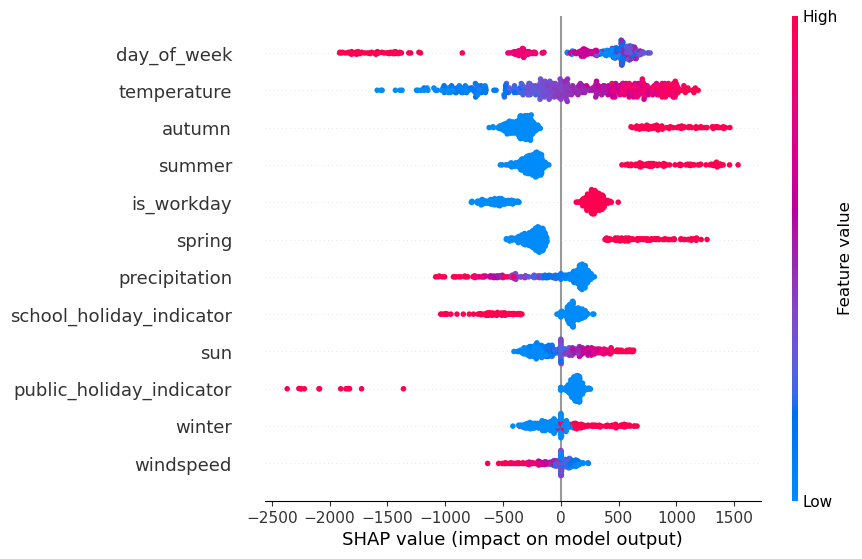

<Figure size 640x480 with 0 Axes>

In [53]:
beeswarm_plot = shap.plots.beeswarm(shap_values_mu_explanation, max_display=15)
plt.tight_layout()
plt.show()
plt.close()

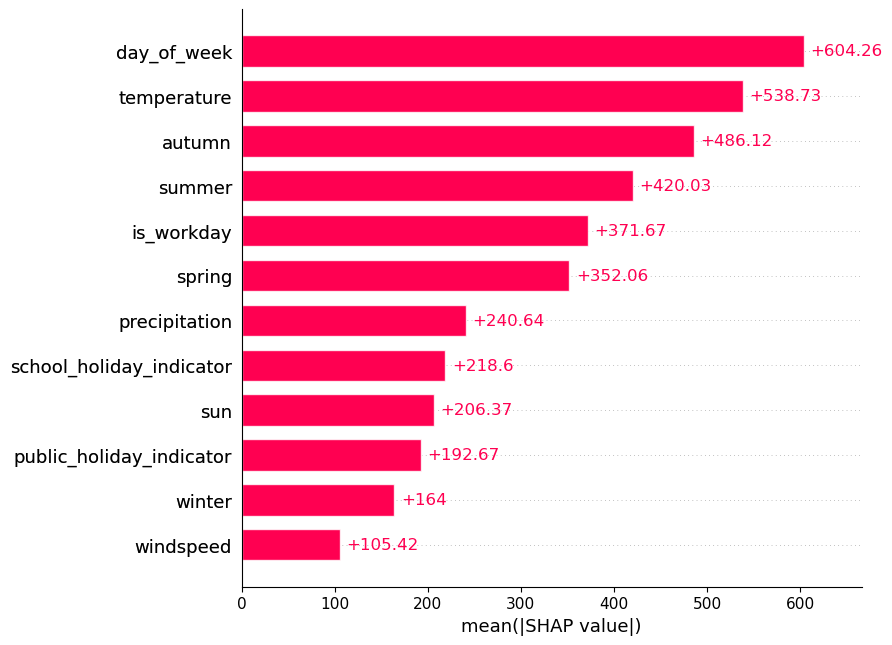

<Figure size 640x480 with 0 Axes>

In [54]:
shap.plots.bar(shap_values_mu_explanation, max_display=15 )
plt.tight_layout()
plt.show()
plt.close()

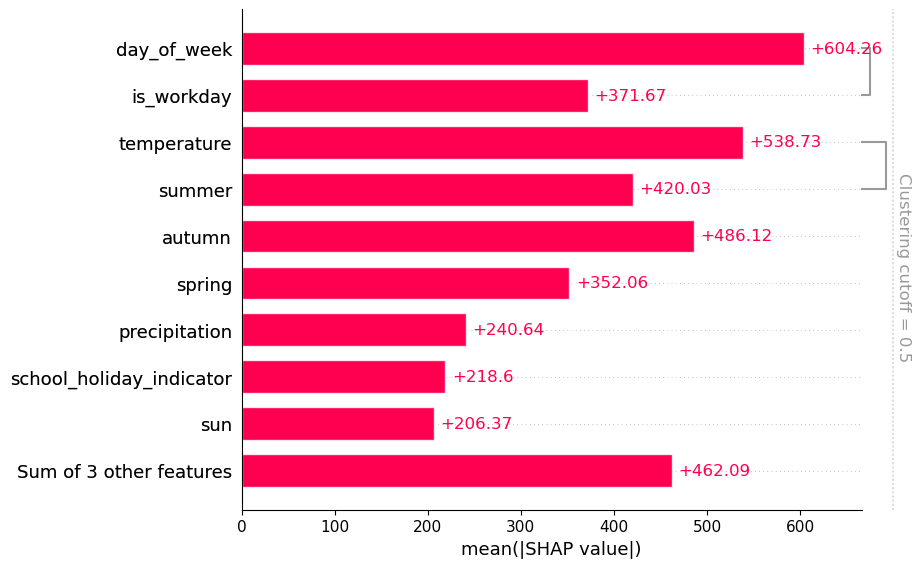

<Figure size 640x480 with 0 Axes>

In [55]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(shap_values_mu_explanation, clustering=clustering)
plt.tight_layout()
plt.show()
plt.close()

### Sigma

In [56]:
shap_values_sigma = shap_values[:, :, 1]

In [57]:
shap_values_sigma_df = pd.DataFrame(shap_values_sigma, columns=X_test.columns)

In [58]:
shap_values_sigma_df.to_csv(r"data\shap_values_df_sigma.csv", index=False)

In [59]:
shap_values_loaded_df_sigma = pd.read_csv(r"data\shap_values_df_sigma.csv")

In [60]:
shap_values_loaded_df_sigma.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,17.037775,10.956194,-210.862124,-57.738809,-88.871362,-22.461977,-31.001582,-41.459288,0.000000,0.000000,-9.031818,-76.607000
1,0.000000,-12.897758,18.705164,29.624056,29.206346,-27.486324,-32.591740,-48.464964,-49.328773,0.000000,-23.804334,-149.952087
2,-58.182152,25.448726,15.305212,39.733299,50.314432,-19.204303,-29.205789,-44.356148,-56.980488,10.834460,2.351727,-142.115002
3,-22.607349,19.218970,20.709671,40.645446,55.440587,-28.974710,-27.939619,-47.051353,-36.833488,-49.050797,-39.917867,-145.304374
4,0.000000,19.282498,14.605610,33.060588,56.438737,-26.117351,-34.769734,-47.861448,-27.616529,-17.240841,-34.435835,-148.029102


In [61]:
shap_values_sigma_loaded = shap_values_loaded_df_sigma.to_numpy()

In [62]:
shap_values_sigma_loaded.shape

(390, 12)

In [63]:
shap_values_sigma_explanation = shap.Explanation(values=shap_values_sigma_loaded, data=X_test)
shap_values_sigma_explanation

.values =
array([[  17.03777526,   10.95619397, -210.86212363, ...,    0.        ,
          -9.03181781,  -76.60700007],
       [   0.        ,  -12.89775804,   18.70516413, ...,    0.        ,
         -23.80433419, -149.95208727],
       [ -58.18215221,   25.44872561,   15.3052116 , ...,   10.83446046,
           2.35172724, -142.11500224],
       ...,
       [ -21.82440631,   15.35628714,   22.5138487 , ...,  -32.21088104,
          -9.46257846,   30.36362978],
       [  22.03362429,  -19.85070471,   19.4338292 , ...,  -34.92477509,
         -36.97160765,   21.51937481],
       [ -13.72435696,    2.12866242,   18.09495698, ...,    4.67462836,
         -10.83659963,   27.51914161]])

.data =
     temperature  precipitation  public_holiday_indicator  is_workday  \
0       0.156666      -0.397192                         1           0   
1      -0.267002       0.014675                         0           1   
2      -0.832871      -0.397192                         0           1   
3   

In [64]:
shap_values_sigma_explanation.feature_names = X_test.columns

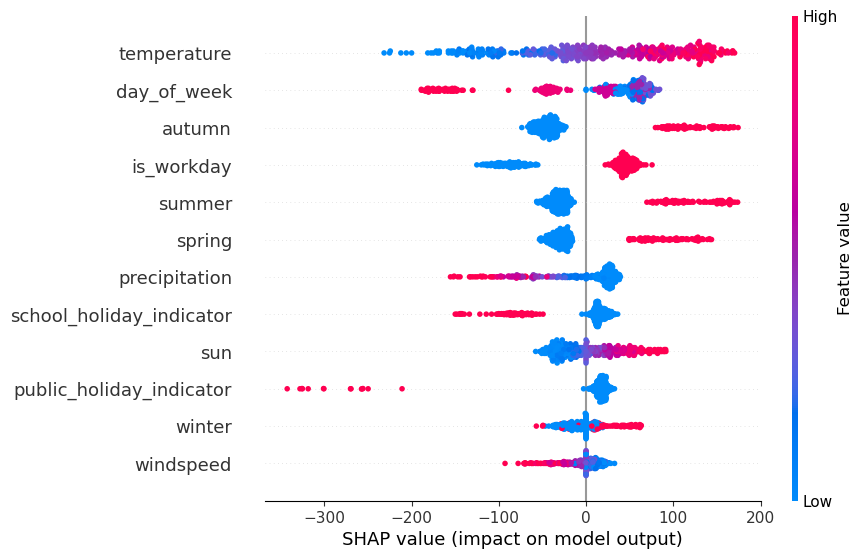

<Figure size 640x480 with 0 Axes>

In [65]:
beeswarm_plot = shap.plots.beeswarm(shap_values_sigma_explanation, max_display=15)
plt.tight_layout()
plt.show()
plt.close()

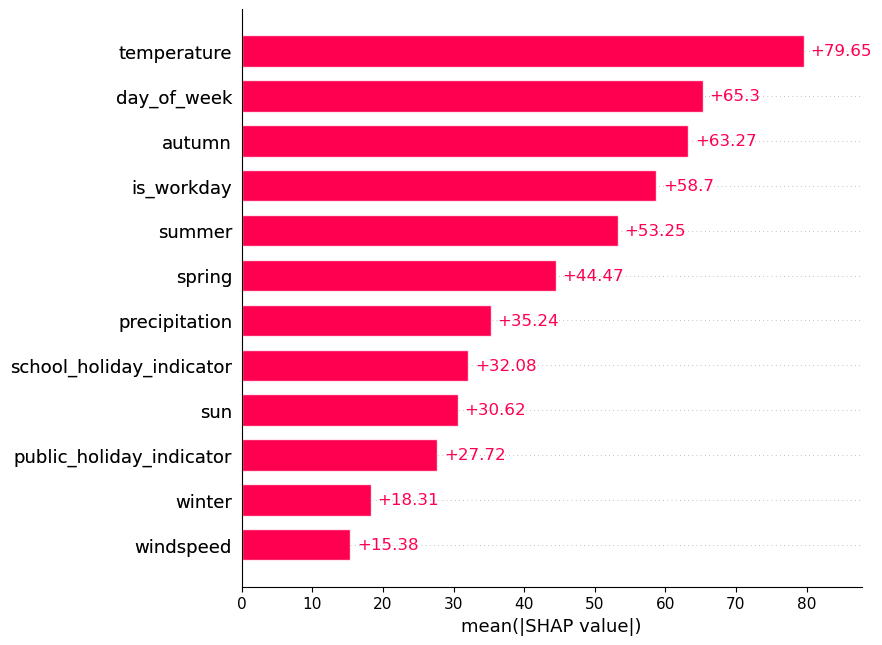

<Figure size 640x480 with 0 Axes>

In [66]:
shap.plots.bar(shap_values_sigma_explanation, max_display=15 )
plt.tight_layout()
plt.show()
plt.close()

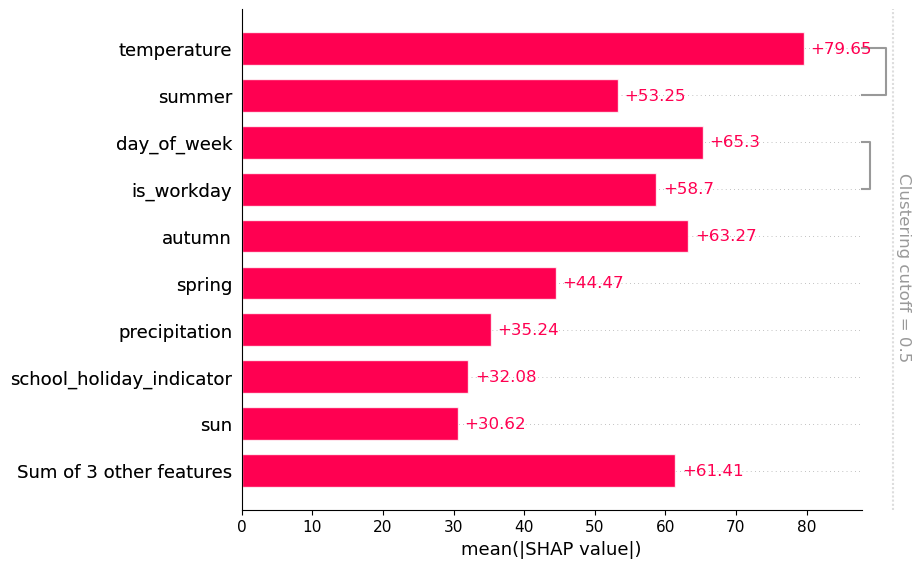

<Figure size 640x480 with 0 Axes>

In [67]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(shap_values_sigma_explanation, clustering=clustering)
plt.tight_layout()
plt.show()
plt.close()